## For investors, is a portfolio/security with higher absolute price increase over a period always more desirable than a portfolio with lower price increase but a higher sharpe ratio given that leverage exists?

In finance, the Sharpe ratio (also known as the Sharpe index, the Sharpe measure, and the reward-to-variability ratio) measures the performance of an investment such as a security or portfolio compared to a risk-free asset, after adjusting for its risk. It is defined as the difference between the returns of the investment and the risk-free return, divided by the standard deviation of the investment returns. It represents the additional amount of return that an investor receives per unit of increase in risk.

It was named after William F. Sharpe, who developed it in 1966.

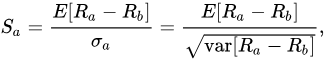 

[Wikipedia](https://www.wikiwand.com/en/articles/Sharpe_ratio)

You might think looking at the below chart that TSLA blew NVDA out of the water in 2024 but our eyes are easily fooled.

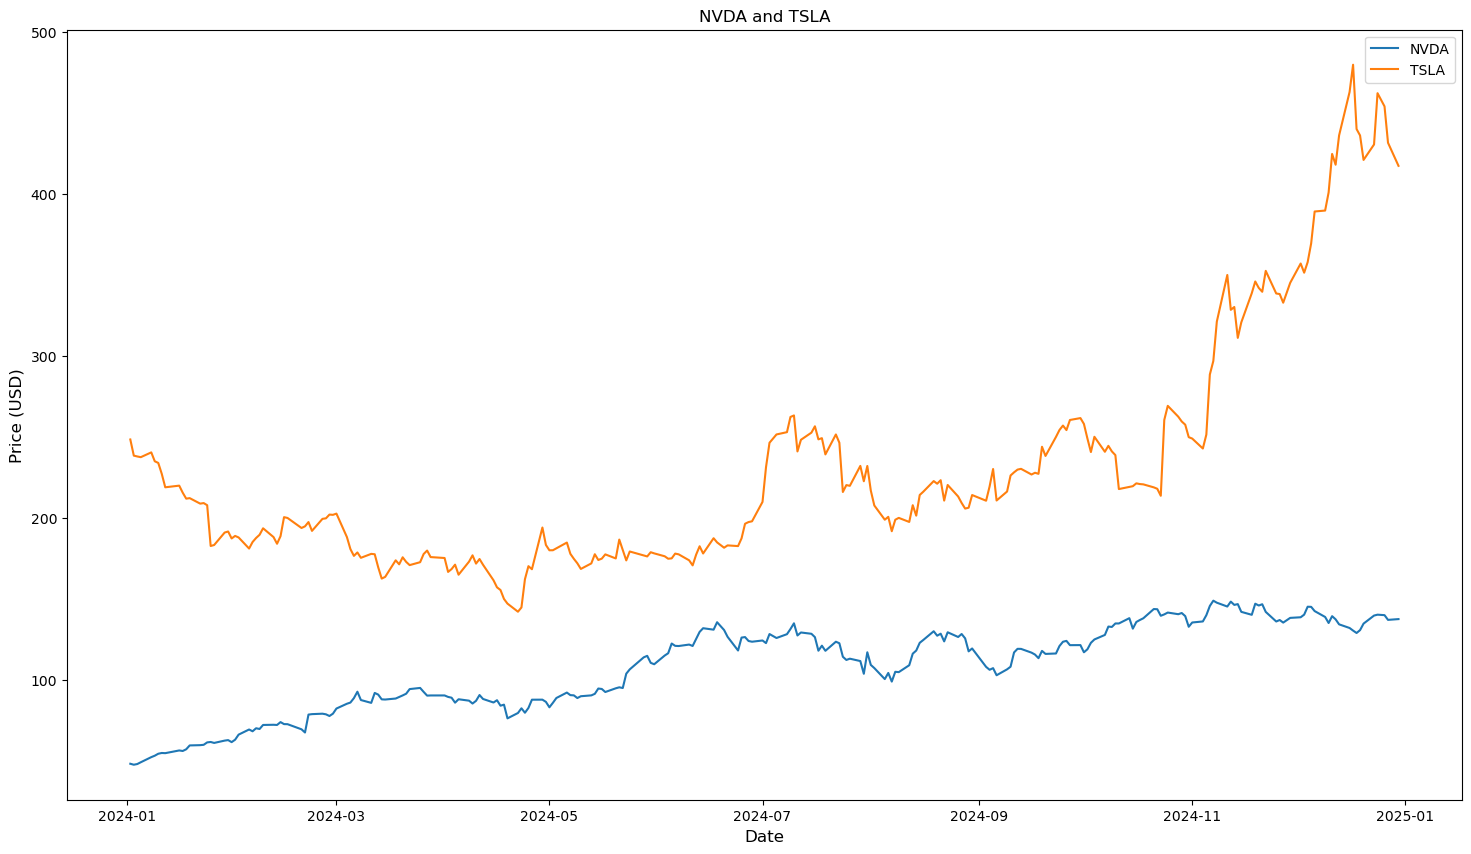

In [43]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

ticker1 = 'NVDA'
ticker2 = 'TSLA'


start_date = pd.to_datetime('2024-01-01')
end_date = pd.to_datetime('2024-12-31')

data1 = yf.Ticker(ticker1).history(start=start_date, end=end_date)
data2 = yf.Ticker(ticker2).history(start=start_date, end=end_date)

plt.figure(figsize=(18, 10))
plt.title(ticker1 + ' and ' + ticker2 )
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.plot(data1['Close'])
plt.plot(data2['Close'])
plt.legend([ticker1, ticker2])
plt.show()


NVDA Sharpe ratio: 2.1903357262515857
TSLA Sharpe ratio: 1.0622499252014004
Portfolio Sharpe ratio: 2.008172748130041


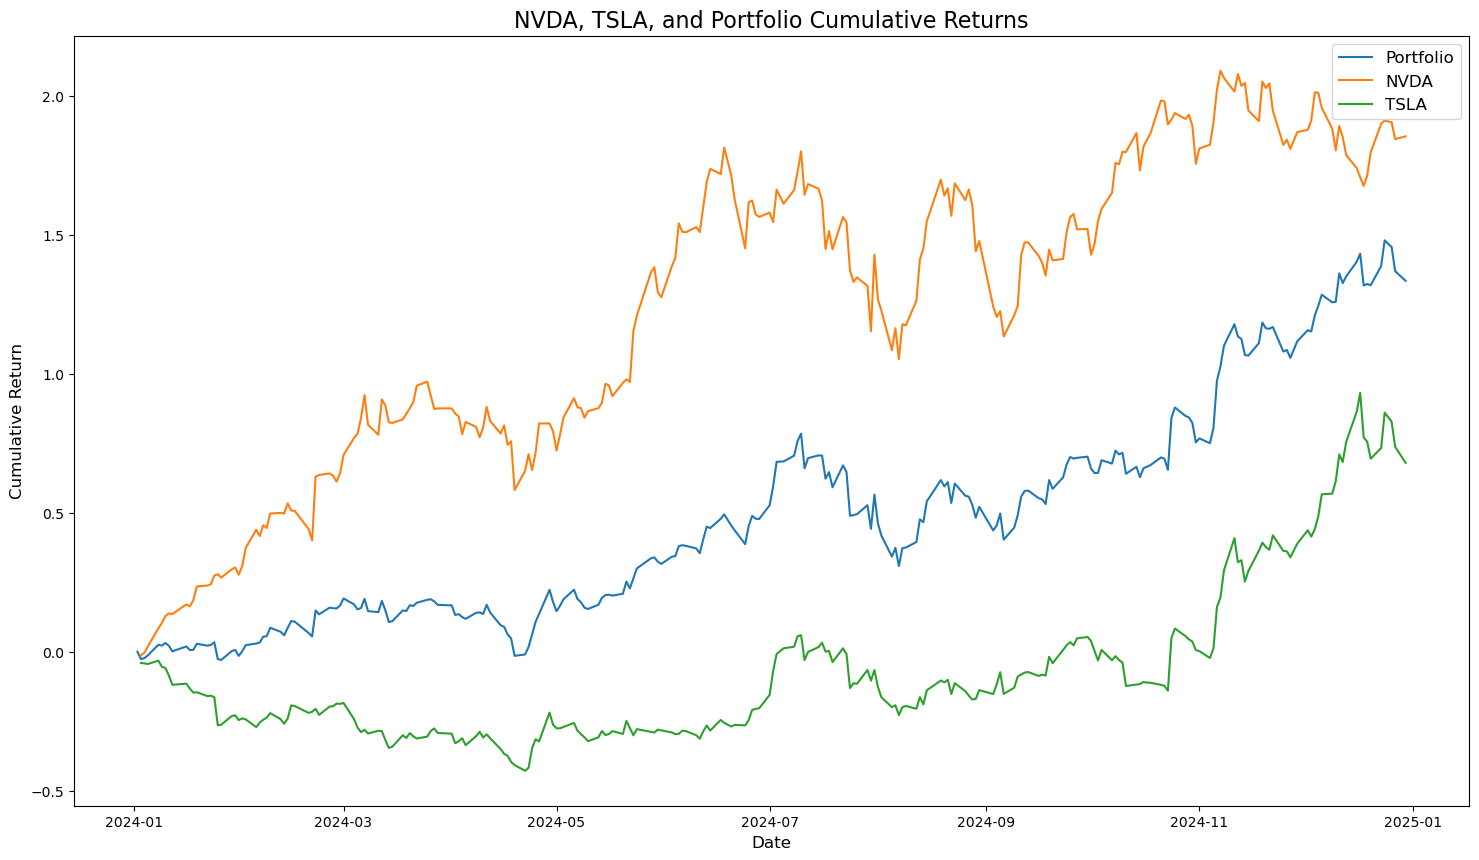

In [44]:
# Percentage change calculation - Fractional change between the current and a prior element [pandas docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pct_change.html)
data1['daily_return'] = data1['Close'].pct_change()
data2['daily_return'] = data2['Close'].pct_change()

# Excess daily return calculation - daily return minus daily risk-free rate, risk-free rate is typically the 10-year treasury bond yield. [treasury bond yield](https://www.cnbc.com/quotes/US10Y)  
risk_free_rate = 0.045  # 4.5% on 1st Jan 2025
daily_risk_free_rate = risk_free_rate / 252 # 252 trading days in a year
data1['excess_daily_return'] = data1['daily_return'] - daily_risk_free_rate
data2['excess_daily_return'] = data2['daily_return'] - daily_risk_free_rate

# Sharpe ratio calculation - average of excess daily return divided by standard deviation of excess daily return, multiplied by square root of 252 (trading days in a year)
data1_sharpe = (data1['excess_daily_return'].mean() * 252) / (data1['excess_daily_return'].std() * (252 ** 0.5))
data2_sharpe = (data2['excess_daily_return'].mean() * 252) / (data2['excess_daily_return'].std() * (252 ** 0.5))

print(ticker1 + ' Sharpe ratio: ' + str(data1_sharpe))
print(ticker2 + ' Sharpe ratio: ' + str(data2_sharpe))

# Portfolio Weighting
weights = [0.5, 0.5]  # 50% allocation to each ticker within the portfolio

# Concatenate daily return data for both tickers into one dataframe to enable easier calculation
portfolio = pd.concat([data1['daily_return'], data2['daily_return']], axis=1)
portfolio.columns = [ticker1, ticker2]

# Daily return for the portfolio
portfolio['portfolio_return'] = (portfolio * weights).sum(axis=1)

# Excess daily return for the portfolio
portfolio['portfolio_excess_return'] = portfolio['portfolio_return'] - daily_risk_free_rate

# Portfolio Sharpe Ratio
portfolio_sharpe = (portfolio['portfolio_excess_return'].mean() / portfolio['portfolio_excess_return'].std()) * (252 ** 0.5)

print('Portfolio Sharpe ratio: ' + str(portfolio_sharpe))

# Cumulative return calculation - Daily return plus 1, cumulative product, minus 1
portfolio['portfolio_cumulative_return'] = (1 + portfolio['portfolio_return']).cumprod() - 1
portfolio[f'{ticker1}_cumulative_return'] = (1 + portfolio[ticker1]).cumprod() - 1
portfolio[f'{ticker2}_cumulative_return'] = (1 + portfolio[ticker2]).cumprod() - 1

plt.figure(figsize=(18, 10))
plt.title(f"{ticker1}, {ticker2}, and Portfolio Cumulative Returns", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.plot(portfolio['portfolio_cumulative_return'], label="Portfolio")
plt.plot(portfolio[f'{ticker1}_cumulative_return'], label=ticker1)
plt.plot(portfolio[f'{ticker2}_cumulative_return'], label=ticker2)
plt.legend(fontsize=12)
plt.show()